# PDAC Subtype Classification using Gene Signatures


Dataset:

• GSE71729(keep only PDAC primary samples)

• Downloadable from the GEO website

Tasks:

• Predict the cancer subtypes based on the signatures

• Identify top N most important genes

• Build new models using only important features

• Compare the performance and stability of two prediction models:

• Suggested ML algorithms: Random Forest, Grand Forest, or other suitable algorithms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE




c:\Users\sharm\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
# File paths
gene_expression_path = r"C:\Users\sharm\Desktop\UNI\1. Sem Python\data provided\gene expression.csv"
gene_signatures_path = r"C:\Users\sharm\Desktop\UNI\1. Sem Python\data provided\gene signatures.csv"
metadata_path = r"C:\Users\sharm\Desktop\UNI\1. Sem Python\data provided\metadata.csv"

In [3]:
# Load data
gene_expression = pd.read_csv(gene_expression_path, index_col=0)
gene_signatures = pd.read_csv(gene_signatures_path)['gene'].tolist()
metadata = pd.read_csv(metadata_path)

## Preprocessing

### check for data imbalance

In [4]:
# Check for data imbalance in 'tumor_subtype_0na_1classical_2basal:ch2'
subtype_counts = metadata['tumor_subtype_0na_1classical_2basal:ch2'].value_counts()

print("\nTumor Subtype Counts:")
print(subtype_counts)

# Determine if there's an imbalance
if len(subtype_counts) == 2:  # Ensure we have both classes present
    classical_count = subtype_counts.get(1, 0)
    basal_count = subtype_counts.get(2, 0)
    
    print(f"\nClassical Tumor Count: {classical_count}")
    print(f"Basal Tumor Count: {basal_count}")
    
    if classical_count != basal_count:
        print("\nThere is a data imbalance between the classical and basal tumor types.")
    else:
        print("\nThe dataset is balanced for the tumor subtypes.")
else:
    print("\nOne or more classes are missing in the dataset.")


Tumor Subtype Counts:
1    103
2     42
Name: tumor_subtype_0na_1classical_2basal:ch2, dtype: int64

Classical Tumor Count: 103
Basal Tumor Count: 42

There is a data imbalance between the classical and basal tumor types.


In [5]:
filtered_gene_expression = gene_expression.loc[gene_signatures].T
filtered_gene_expression.index.name = 'geo_accession'
merged_data = metadata.merge(filtered_gene_expression, left_on='geo_accession', right_index=True)

X = merged_data[gene_signatures]
y = merged_data['tumor_subtype_0na_1classical_2basal:ch2']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Initial train-test split: 80% train (to be split again) and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training set into training and validation sets: 75% train, 25% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

# Train model 1- Random forest

In [6]:
rf_model_cv = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')

# Initially, use the train-validation split 
rf_model_cv.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [7]:
# Evaluate on validation set
val_accuracy_rf = rf_model_cv.score(X_val, y_val)
print("Random Forest Initial Validation Set Accuracy: %0.2f" % val_accuracy_rf)

Random Forest Initial Validation Set Accuracy: 0.83


In [8]:
# Hyperparameter Tuning with GridSearchCV using Validation Set
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model_cv, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), 
                           n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [9]:
# Evaluate on validation set after tuning
best_rf_model = grid_search.best_estimator_
val_accuracy_rf_tuned = best_rf_model.score(X_val, y_val)
print("Random Forest Tuned Validation Set Accuracy: %0.2f" % val_accuracy_rf_tuned)

# Final evaluation on test set
test_accuracy_rf = best_rf_model.score(X_test, y_test)
print("Random Forest Test Set Accuracy: %0.2f" % test_accuracy_rf)

Random Forest Tuned Validation Set Accuracy: 0.86
Random Forest Test Set Accuracy: 0.97


In [10]:
# Train Random Forest on training data
rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred_rf = rf_model.predict(X_val)
val_accuracy_rf_tuned = accuracy_score(y_val, y_val_pred_rf)
print("Random Forest Tuned Validation Set Accuracy: %0.2f" % val_accuracy_rf_tuned)

# Print classification report for validation set
print("Classification Report for Random Forest on Validation Set:")
print(classification_report(y_val, y_val_pred_rf))

# Final evaluation on the test set
y_test_pred_rf = rf_model.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("Random Forest Test Set Accuracy: %0.2f" % test_accuracy_rf)

# Print classification report for test set
print("Classification Report for Random Forest on Test Set:")
print(classification_report(y_test, y_test_pred_rf))

# Repeat similar steps for SVM or other models


Random Forest Tuned Validation Set Accuracy: 0.86
Classification Report for Random Forest on Validation Set:
              precision    recall  f1-score   support

           1       0.83      1.00      0.91        20
           2       1.00      0.56      0.71         9

    accuracy                           0.86        29
   macro avg       0.92      0.78      0.81        29
weighted avg       0.89      0.86      0.85        29

Random Forest Test Set Accuracy: 0.97
Classification Report for Random Forest on Test Set:
              precision    recall  f1-score   support

           1       0.95      1.00      0.98        21
           2       1.00      0.88      0.93         8

    accuracy                           0.97        29
   macro avg       0.98      0.94      0.96        29
weighted avg       0.97      0.97      0.96        29



## Train model 2- Random forest with selected features

In [11]:
# Train Random Forest for feature importance
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.01174757 0.00749463 0.03153437 0.00453815 0.00334629 0.00356263
 0.00531018 0.02444429 0.0280818  0.0146742  0.00370503 0.01525912
 0.03194778 0.01206135 0.00871578 0.03243144 0.00306668 0.00246905
 0.02654579 0.00324324 0.01328907 0.02388551 0.00720166 0.00627059
 0.01819283 0.00600961 0.00343279 0.0500614  0.00503511 0.003032
 0.02139349 0.00549962 0.01725898 0.00688847 0.00601667 0.01836762
 0.01212754 0.01625534 0.03918005 0.04086486 0.01981843 0.14624806
 0.0721886  0.00443066 0.00869171 0.00643325 0.08903166 0.00518174
 0.01513851 0.03839479]


In [12]:
# Select the top 'n' important features
n = 20  
indices_of_important_features = np.argsort(feature_importances)[-n:]

# Reduce the training and test sets to only the important features
X_train_rf_top = X_train.iloc[:, indices_of_important_features]
X_test_rf_top = X_test.iloc[:, indices_of_important_features]
X_val_rf_top = X_val.iloc[:, indices_of_important_features]

# Print selected features if feature names are available
print("Selected Features (by index):", indices_of_important_features)

Selected Features (by index): [37 32 24 35 40 30 21  7 18  8  2 12 15 49 38 39 27 42 46 41]


In [13]:
rf_model_cv = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model_cv.fit(X_train_rf_top, y_train)

# Evaluate on validation set
val_accuracy_rf = rf_model_cv.score(X_val_rf_top, y_val)
print("Random Forest Initial Validation Set Accuracy: %0.2f" % val_accuracy_rf)


Random Forest Initial Validation Set Accuracy: 0.83


In [19]:
# Hyperparameter tuning with GridSearchCV using Validation Set
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model_cv, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), 
                           n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train_rf_top, y_train)

# Best parameters from Grid Search
best_params_rf = grid_search.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [20]:
# Evaluate on validation set after tuning
best_rf_model = grid_search.best_estimator_
val_accuracy_rf_tuned = best_rf_model.score(X_val_rf_top, y_val)
print("Random Forest Tuned Validation Set Accuracy: %0.2f" % val_accuracy_rf_tuned)


Random Forest Tuned Validation Set Accuracy: 0.90


In [21]:
# Final evaluation on test set
test_accuracy_rf = best_rf_model.score(X_test_rf_top, y_test)
print("Random Forest Test Set Accuracy: %0.2f" % test_accuracy_rf)


Random Forest Test Set Accuracy: 0.90


In [22]:
# Make predictions and evaluate the optimized Random Forest model
pred_rf_top = best_rf_model.predict(X_test_rf_top)

# Print classification report for the test set
print("Optimized Random Forest with Important Features Report")
print(classification_report(y_test, pred_rf_top))

Optimized Random Forest with Important Features Report
              precision    recall  f1-score   support

           1       0.91      0.95      0.93        21
           2       0.86      0.75      0.80         8

    accuracy                           0.90        29
   macro avg       0.88      0.85      0.87        29
weighted avg       0.89      0.90      0.89        29



Random Forest Accuracy (All Features): 0.97
Random Forest Accuracy (Selected Features): 0.90


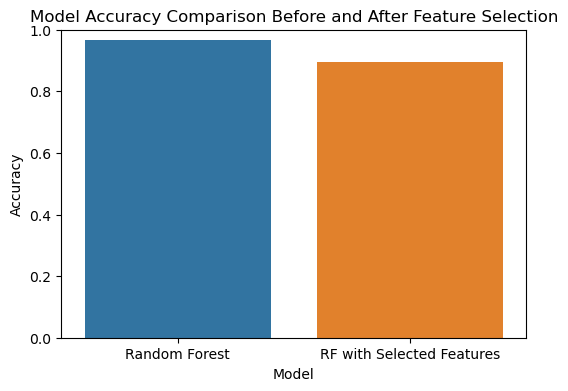

In [23]:
# Compare accuracies before and after feature selection
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_top_accuracy = accuracy_score(y_test, pred_rf_top)

print(f"Random Forest Accuracy (All Features): {rf_accuracy:.2f}")
print(f"Random Forest Accuracy (Selected Features): {rf_top_accuracy:.2f}")

# Visualize comparison
metrics = {
    'Model': ['Random Forest', 'RF with Selected Features'],
    'Accuracy': [rf_accuracy, rf_top_accuracy]
}
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison Before and After Feature Selection')
plt.ylim(0, 1)
plt.show()

# Train model 3- SVM

In [24]:
# Initialize the SVM Model
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train on the initial training set
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [25]:
# Evaluate on the validation set
val_accuracy_svm = svm_model.score(X_val, y_val)
print("SVM Initial Validation Set Accuracy: %0.2f" % val_accuracy_svm)


SVM Initial Validation Set Accuracy: 0.97


In [31]:
# Define parameter grid for SVM including class_weight
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

# Choose a metric that handles imbalance better, e.g., 'f1' or 'roc_auc'
svm_grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid=svm_param_grid, 
                               cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1, verbose=2)

# Fit the grid search object
svm_grid_search.fit(X_train, y_train)

# Get the best model
best_svm_model = svm_grid_search.best_estimator_

# Best parameters from Grid Search
best_params_svm = svm_grid_search.best_params_
print("Best Parameters for Random Forest:", best_params_svm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Random Forest: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


In [32]:
# Evaluate on validation set after tuning
val_accuracy_svm_tuned = best_svm_model.score(X_val, y_val)
print("SVM Tuned Validation Set Accuracy: %0.2f" % val_accuracy_svm_tuned)

# Evaluate the optimized model on the test set
test_accuracy_svm = best_svm_model.score(X_test, y_test)
print("SVM Test Set Accuracy: %0.2f" % test_accuracy_svm)


SVM Tuned Validation Set Accuracy: 0.97
SVM Test Set Accuracy: 1.00


In [33]:
# Make predictions and evaluate the optimized SVM model
y_pred_svm = best_svm_model.predict(X_test)

# Print classification report for the test set
print("Optimized SVM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Optimized SVM Performance:
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         8

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



## Train model 4- SVM with selected features

In [34]:
# Step 1: Select Top Features with RFE
svc = SVC(kernel="linear", random_state=42)
rfe = RFE(estimator=svc, n_features_to_select=20, step=1)

# Fit RFE on the training set
X_train_top_svm = rfe.fit_transform(X_train, y_train)

# Apply transformation to the validation and test sets
X_val_top_svm = rfe.transform(X_val)
X_test_top_svm = rfe.transform(X_test)

# Optional: Check which features were selected
selected_features = rfe.support_
print("Selected Features:", selected_features)

Selected Features: [False  True  True False False False  True  True False False  True False
  True False  True  True  True False False False False False False False
  True False False False False False  True  True  True False False  True
 False False  True  True  True  True  True False False False  True False
 False False]


In [35]:
# Step 2: Hyperparameter Tuning with GridSearchCV using Validation Set
svm_param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear'],  # Using linear kernel
    'class_weight': ['balanced']  # To handle class imbalance
}

grid_search_svm = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=StratifiedKFold(n_splits=5), 
                               scoring='accuracy', n_jobs=-1, verbose=2)

grid_search_svm.fit(X_train_top_svm, y_train)

# Best parameters from Grid Search
best_params = grid_search_svm.best_params_
print("Best Parameters for SVM with Selected Features:", best_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for SVM with Selected Features: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


In [36]:
# Step 3: Evaluation on Validation Set
# Train the SVM model with selected features using the best parameters
svm_model_top = SVC(**best_params, random_state=42)
svm_model_top.fit(X_train_top_svm, y_train)

# Evaluate on validation set
val_accuracy_svm_top = svm_model_top.score(X_val_top_svm, y_val)
print("SVM Validation Set Accuracy with Selected Features: %0.2f" % val_accuracy_svm_top)

# Step 4: Final Test Set Evaluation
# Make predictions and evaluate the optimized SVM model
pred_svm_top = svm_model_top.predict(X_test_top_svm)
test_accuracy_svm_top = accuracy_score(y_test, pred_svm_top)
print("SVM Test Set Accuracy with Selected Features: %0.2f" % test_accuracy_svm_top)

print("SVM with Top Features Report")
print(classification_report(y_test, pred_svm_top))

SVM Validation Set Accuracy with Selected Features: 0.97
SVM Test Set Accuracy with Selected Features: 1.00
SVM with Top Features Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         8

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



## Accuracy score of training and testing dataset

In [38]:
# Predicting on the training set
y_train_pred = rf_model.predict(X_train)

# Predicting on the validation set
y_val_pred = rf_model.predict(X_val)

# Predicting on the testing set
y_test_pred = rf_model.predict(X_test)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy RF: {train_accuracy:.2f}")
print(f"Validation Set Accuracy RF: {val_accuracy:.2f}")
print(f"Testing Set Accuracy RF: {test_accuracy:.2f}")


Training Set Accuracy RF: 1.00
Validation Set Accuracy RF: 0.86
Testing Set Accuracy RF: 0.97


In [39]:
# Predicting on the training set
y_train_pred = best_rf_model.predict(X_train_rf_top)

# Predicting on the validation set
y_val_pred = best_rf_model.predict(X_val_rf_top)

# Predicting on the testing set
y_test_pred = best_rf_model.predict(X_test_rf_top)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy RF-selected features: {train_accuracy:.2f}")
print(f"Validation Set Accuracy RF-selected features: {val_accuracy:.2f}")
print(f"Testing Set Accuracy RF- selected features: {test_accuracy:.2f}")

Training Set Accuracy RF-selected features: 1.00
Validation Set Accuracy RF-selected features: 0.90
Testing Set Accuracy RF- selected features: 0.90


In [40]:
# Predicting on the training set
y_train_pred = svm_model.predict(X_train)

# Predicting on the validation set
y_val_pred = svm_model.predict(X_val)

# Predicting on the testing set
y_test_pred = svm_model.predict(X_test)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy SVM: {train_accuracy:.2f}")
print(f"Validation Set Accuracy RF: {val_accuracy:.2f}")
print(f"Testing Set Accuracy SVM: {test_accuracy:.2f}")

Training Set Accuracy SVM: 1.00
Validation Set Accuracy RF: 0.97
Testing Set Accuracy SVM: 1.00


In [44]:
# Predicting on the training set
y_train_pred = svm_model_top.predict(X_train_top_svm)

# Predicting on the validation set
y_val_pred = svm_model_top.predict(X_val_top_svm)

# Predicting on the testing set
y_test_pred = svm_model_top.predict(X_test_top_svm)

# Calculating accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the accuracies
print(f"Training Set Accuracy SVM-selected features: {train_accuracy:.2f}")
print(f"Validation Set Accuracy SVM-selected features: {val_accuracy:.2f}")
print(f"Testing Set Accuracy SVM-selected features: {test_accuracy:.2f}")

Training Set Accuracy SVM-selected features: 1.00
Validation Set Accuracy SVM-selected features: 0.97
Testing Set Accuracy SVM-selected features: 1.00


# Compare metrics

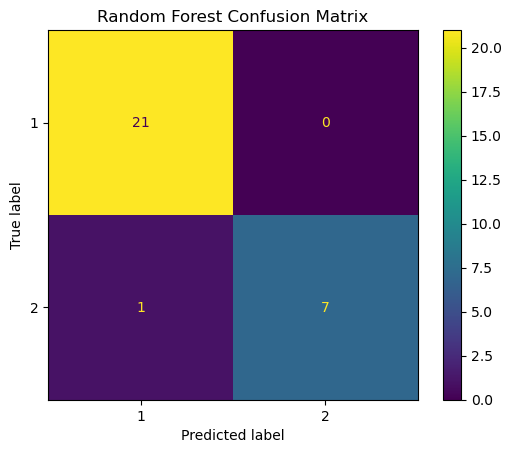

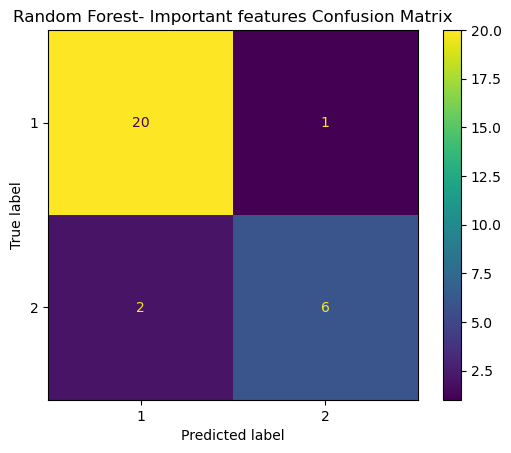

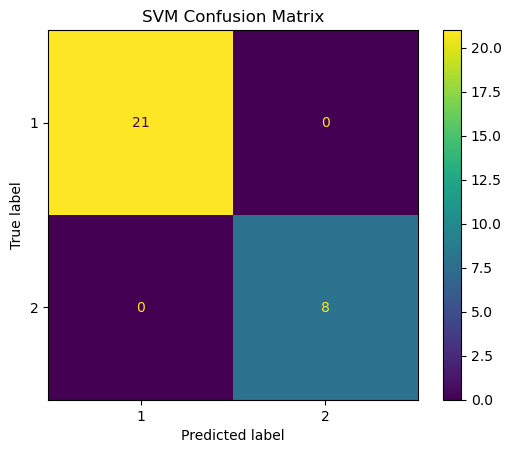

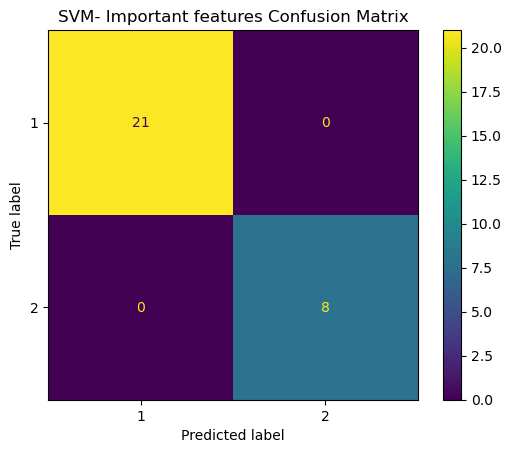

In [45]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test).ax_.set_title('Random Forest Confusion Matrix')
plt.show()

ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test_rf_top, y_test).ax_.set_title('Random Forest- Important features Confusion Matrix')
plt.show()


ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test).ax_.set_title('SVM Confusion Matrix')
plt.show()

ConfusionMatrixDisplay.from_estimator(svm_model_top, X_test_top_svm, y_test).ax_.set_title('SVM- Important features Confusion Matrix')
plt.show()

# compare metrics

Random Forest Accuracy: 0.97
Random Forest with Selected Features Accuracy: 0.90
SVM Accuracy: 1.00
SVM with Selected Features Accuracy: 1.00


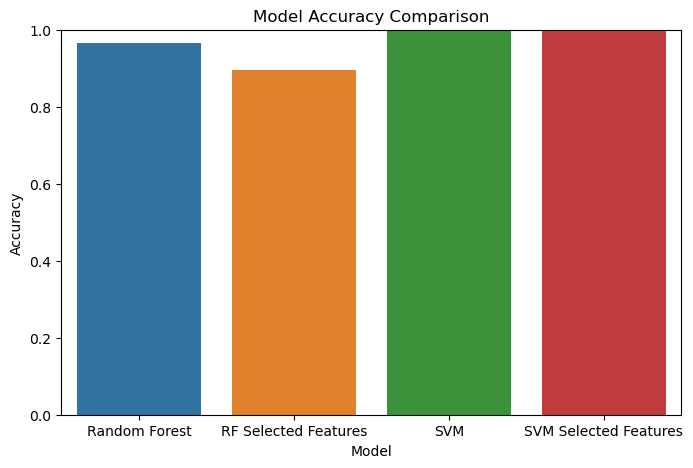

In [46]:
# Compare accuracy
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_top_accuracy = accuracy_score(y_test, pred_rf_top)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_top_accuracy = accuracy_score(y_test, pred_svm_top)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest with Selected Features Accuracy: {rf_top_accuracy:.2f}")
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print(f"SVM with Selected Features Accuracy: {svm_top_accuracy:.2f}")

# Visualize model comparison
metrics = {'Model': ['Random Forest', 'RF Selected Features', 'SVM', 'SVM Selected Features'], 'Accuracy': [rf_accuracy, rf_top_accuracy, svm_accuracy, svm_top_accuracy]}
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()
